## Table of Contents
- [Global Import](#global-import)
    - [Main Functions](#main-functions)
- [Data Preprocessing](#data-preprocessing)    
    - [Unpacking](#unpacking)
        - [`"proj_xz.pkl"`](#proj_xz-pkl)
        - [`"input.dat"`](#input-dat)
    - [Creating Input Dataset](#creating-input-dataset)
        - [Spike Times](#spike-times)
        - [Batches](#batches)
        - [`stim_train`](#stim-train)
            - [Batches vs `stim_train`](#batches-vs-stim)
        - [GID to `xz_array` Index & Creating `x_data`](#creating-x-data)
- [Autoencoder](#autoencoder)
    - [Building](#building)
    - [Training](#training)
        - [Simple Autoencoder](#simple-autoencoder)
        - [Sparse Autoencoder](#sparse-autoencoder)
        - [Low-dimentional Auroencoder](#lim-dim-ae)
- [Readout/Classifier](#readout)
    - [Dataset Preparation](#dataset-preparation)
    - [Building](#cl_building)
    - [Training](#cl_training)
- [Analysis](#analysis)
    - [Analytical Tools Development](#analytical-tools-development)
        - [Comparative Histogram](#comparative-histogram)
        - [Comparative Animation](#comparative-animation)
        - [Working with Patterns](#working-with-patterns)
            - [Pattern Sums](#pattern-sums)
            - [Pattern Distributions](#pattern-sums)
            - [Summary Table](#summary-table)
        - [Dimensional Representation Visualization](#dim-repr-viz)
            - [Example Table](#ex-table)
        - [Weights Visualization](#weights-viz)
        - [Custering Visualization](#clustering-viz)
            - [8D AE Summary Table](#8d-ae-table)
- [TODO](#todo)
- [Project Log](#project-log)

# Global Import <a class="anchor" id="global-import"></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors

import numpy as np
np.set_printoptions(suppress=True)

import pickle as pkl

from keras.models import load_model

Using TensorFlow backend.


## Main Functions <a class="anchor" id="main-functions"></a>

In [2]:
with open('data/input/xz_array.pkl', 'rb') as f:
    xz_array = pkl.load(f)

In [228]:
def plot(data, titles=None, fig_title="", plot_name="title.png", show=False, save=True, ticksize=None, scale_to_01=True):
    if titles == None:
        titles = [""]*len(data)
        
    """Plots valued scatter plots."""
    fig, axs = plt.subplots(1, len(data), sharey=True, figsize=(4*len(data), 4))
    if len(data) == 1:
        axs = [axs]
    
    if scale_to_01:
        norm = colors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.get_cmap('plasma')
    rgba = cmap(0)

    fig.suptitle(fig_title)
    
    for ax, title in zip(axs, titles):
        ax.set_title(title)
        ax.set(adjustable='box-forced', aspect='equal')
        ax.set_facecolor(rgba)      
    
    images = [axs[i].scatter(xz_array[:, 1], xz_array[:, 2], c=np.zeros(xz_array.shape[0]), s=3, cmap='plasma') \
              for i in range(len(axs))]
    
    cbar = fig.colorbar(images[0], ax=list(axs), orientation='vertical', fraction=.02)
    if ticksize != None:
        cbar.ax.tick_params(labelsize=ticksize)
    
    if len(data[0].shape) == 1:
        for i, im in enumerate(images):
            if not scale_to_01:
                norm = colors.Normalize(vmin=np.min(data[i]), vmax=np.max(data[i]))
            im.set_norm(norm)
            im.set_array(data[i].reshape(-1))
        
        if save == True:
            fig.savefig('data/incite/{}'.format(plot_name), dpi=300)
    else:
        def update(frame):
            for i, im in enumerate(images):
                if not scale_to_01:
                    norm = colors.Normalize(vmin=np.min(data[i]), vmax=np.max(data[i]))
                im.set_norm(norm)
                im.set_array(data[i][frame])
            return images

        ani = animation.FuncAnimation(fig, update, frames=data[0].shape[0],\
                                      interval=1000, blit=True)
        if save == True:
            ani.save("data/incite/{}.mp4".format(plot_name), dpi=300)
        
    if show == True:
        plt.show()
        
    plt.close('all')

# Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

> Please find attached an exemplar input file for the simulations we are running.

> I also attached a dictionary with the X and Z coordinate of each innervating fiber.

> Stimuli are presented every 200 ms.

## Unpacking <a class="anchor" id="unpacking"></a>
### `"proj_xz.pkl"` <a class="anchor" id="proj_xz-pkl"></a>

In [4]:
with open('data/input/proj_xz.pkl', 'rb') as f:
    xz_glob = pkl.load(f, encoding='latin1')

In [5]:
xz_array = np.zeros((1, 2))
keys = []
for key in xz_glob:
    keys.append(key)
    xz_array = np.concatenate((xz_array, xz_glob[key].reshape((1, 2))), axis=0)
keys = np.array(keys).reshape(-1, 1)
xz_array = np.concatenate((keys, xz_array[1:]), axis=1)

In [6]:
xz_array

array([[ 221184.   ,     489.488,     591.93 ],
       [ 221185.   ,     206.701,     563.71 ],
       [ 221186.   ,     319.906,     457.568],
       ..., 
       [ 221181.   ,     250.45 ,     495.846],
       [ 221182.   ,     479.566,     650.127],
       [ 221183.   ,     391.449,     464.526]])

In [7]:
with open('data/input/xz_array.pkl', 'wb') as f:
    pkl.dump(xz_array, f)

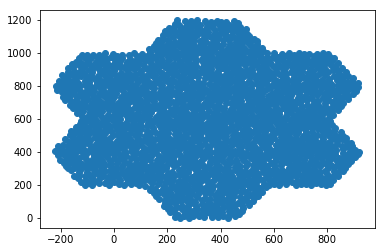

In [8]:
plt.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
plt.show()

### `"input.dat"` <a class="anchor" id="input-dat"></a>
- `"input.dat"` contains spiking times paired with GIDs (global IDs)
- Patterns go in 200 ms packs
- To make pictures, add up activities over each 200 ms

In [9]:
input_ = np.loadtxt('data/input/input.dat', skiprows=1)
input_ = np.flip(input_, axis=1)

In [10]:
print(input_)
print(input_.shape)

[[ 221184.          1200.406006]
 [ 221184.          1801.768311]
 [ 221184.          1864.717529]
 ..., 
 [ 221183.         26553.761719]
 [ 221183.         27957.466797]
 [ 221183.         29371.466797]]
(77654, 2)


In [11]:
print("Avg fibres per spike time: {}".format(input_.shape[0] / np.unique(input_[:, 1]).shape[0]))

Avg fibres per spike time: 21.685004188774087


## Creating Input Dataset <a class="anchor" id="creating-input-dataset"></a>

### Spike Times <a class="anchor" id="spike-times"></a>

In [12]:
# Take all GIDs for each unique spike time.
times = np.unique(input_[:, 1])
times_ids = [input_[:, 0][np.argwhere(input_ == i)[:, 0]] for i in times]

In [13]:
times_ids[0]

array([ 220747.,  220750.,  220756.,  220762.,  220765.,  220773.,
        220774.,  220778.,  220781.,  220786.,  220788.,  220796.,
        220801.,  220806.,  220808.,  220809.,  220821.,  220826.,
        220828.,  220837.,  220849.,  220862.,  220873.,  220898.])

In [14]:
# Translate GIDs into coordinates for each spike time.
times_xz = []
for ids in times_ids:
    a = [xz_array[np.argwhere(xz_array == id_)[:, 0], :] for id_ in ids]
    times_xz.append(np.concatenate(a))

In [15]:
# `times_xz` - list of GIDs for each spike time (with coordinates), list of 2darrays.
print(len(times_xz))
print(times_xz[0].shape)
print(times_xz[0][:10])

3581
(24, 3)
[[ 220747.        -37.143     429.791]
 [ 220750.        -47.967     414.168]
 [ 220756.        -35.846     447.929]
 [ 220762.        -54.281     438.775]
 [ 220765.        -66.346     412.825]
 [ 220773.        -71.532     430.597]
 [ 220774.        -45.261     463.382]
 [ 220778.        -83.033     397.495]
 [ 220781.        -68.714     451.273]
 [ 220786.        -33.083     481.641]]


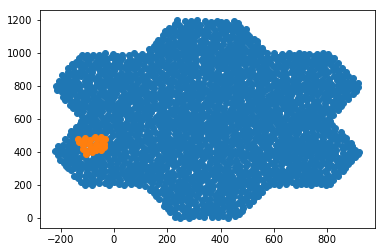

In [16]:
plt.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
plt.scatter(times_xz[0][:, 1], times_xz[0][:, 2]) # single spike time pattern
plt.show()

### Batches <a class="anchor" id="batches"></a>

In [17]:
# Bin spike times into 200 ms intervals.
def batch(times, ms):
    batches_num = []
    batch_num = 0
    i_start = 0
    for i, time in enumerate(times):
        num = int(time // ms)
        if num > batch_num:
            batch_num = num
            batches_num.append(slice(i_start, i))
            i_start = i
        if i == len(times)-1:
            batches_num.append(slice(i_start, i+1))
    # Skip first second of random spiking.
    batches_num = batches_num[5:]
    return batches_num

In [18]:
batches_200 = batch(times, 200)

In [19]:
# `batches_200` - slices of indices for `times_xz` (200 ms batch times).
print(len(batches_200))
for i, batch in enumerate(batches_200):
    if i > 9:
        break
    else:
        print(batch)

145
slice(48, 74, None)
slice(74, 99, None)
slice(99, 121, None)
slice(121, 141, None)
slice(141, 169, None)
slice(169, 189, None)
slice(189, 217, None)
slice(217, 240, None)
slice(240, 263, None)
slice(263, 287, None)


In [20]:
# Make an animation representing all relevant 200 ms batches.
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(xz_array[:, 1], xz_array[:, 2])
ln, = ax.plot([], [], 'o', alpha=0.5, animated=True)

ax.set(adjustable='box-forced', aspect='equal')

def update(frame):
    xz = np.vstack(times_xz[batches_200[frame]])
    ln.set_data(xz[:, 1], xz[:, 2])
    return ln,

ani = animation.FuncAnimation(fig, update, frames=len(batches_200),\
                              interval=500, blit=True)
ani.save("data/incite/batches_200.mp4", dpi=300)

### `stim_train` <a class="anchor" id="stim-train"></a>

In [21]:
stim_train = [249980, 397555, 446691, 205315, 397555, 249980, \
              757795, 397555, 740558, 249980, 397555, 249980, \
              766947, 740558, 446691, 766947, 205315, 205315, \
              766947, 515018, 740558, 740558, 249980, 515018, \
              757795, 740558, 515018, 397555, 740558, 249980, \
              446691, 397555, 757795, 766947, 757795, 397555, \
              766947, 740558, 446691, 766947, 205315, 740558, \
              757795, 515018, 397555, 397555, 249980, 515018, \
              205315, 446691, 205315, 205315, 446691, 740558, \
              446691, 205315, 249980, 515018, 766947, 446691, \
              757795, 397555, 757795, 397555, 757795, 515018, \
              740558, 757795, 446691, 397555, 249980, 446691, \
              515018, 515018, 446691, 515018, 766947, 249980, \
              515018, 757795, 766947, 205315, 740558, 515018, \
              205315, 740558, 205315, 766947, 740558, 249980, \
              205315, 205315, 515018, 740558, 515018, 446691, \
              397555, 757795, 766947, 515018, 397555, 205315, \
              397555, 397555, 205315, 249980, 740558, 397555, \
              757795, 249980, 757795, 766947, 446691, 757795, \
              766947, 766947, 446691, 446691, 757795, 515018, \
              446691, 446691, 766947, 740558, 740558, 766947, \
              515018, 249980, 757795, 446691, 249980, 766947, \
              205315, 446691, 249980, 766947, 757795, 249980, \
              249980, 397555, 515018, 757795, 249980, 397555, 205315]

In [22]:
stim_train = np.array(stim_train)

In [23]:
with open('data/input/stim_train.pkl', 'wb') as f:
    pkl.dump(stim_train, f)

In [24]:
np.unique(stim_train)

array([205315, 249980, 397555, 446691, 515018, 740558, 757795, 766947])

In [25]:
len(stim_train)

145

#### Batches vs `stim_train`  <a class="anchor" id="batches-vs-stim"></a>
Check whether the 200 ms batches correctly represent `stim_train`.

In [26]:
# Contains GIDs for each 200 ms batch.
times_batched = [np.sort(np.vstack(times_xz[batch])[:, 0]) for batch in batches_200]

In [27]:
len(times_batched)

145

In [28]:
# Hash to check unique batches.
times_batched_hashed = [hash(batch.tostring()) for batch in times_batched]

In [29]:
np.unique(times_batched_hashed).shape

(145,)

This means that every batch has a unique set of fibres, which is how it should be.

**NB** This ↓ is equivalent to [**pattern sums**](#pattern-sums).

[  3  16  17  40  48  50  51  55  81  84  86  90  91 101 104 132 144]


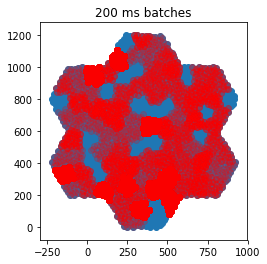

In [31]:
# Pick all indices from `stim_train` with the same specific value (representing the same pattern).
# 200 ms batches
pick = np.argwhere(stim_train == 205315).reshape(-1)
print(pick)

fig, ax = plt.subplots(figsize=(4, 4))

ax.set_title('200 ms batches')
ax.set(adjustable='box-forced', aspect='equal')
ax.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
for i in pick:
    xz = np.vstack(times_xz[batches_200[i]])
    ax.scatter(xz[:, 1], xz[:, 2], c='r', alpha=0.2)
plt.show()

Plot all the input frames representing the same pattern (`pick` from previous cell).

In [32]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(xz_array[:, 1], xz_array[:, 2])
ln, = ax.plot([], [], 'ro', alpha=0.5, animated=True)

ax.set(adjustable='box-forced', aspect='equal')

def update(frame):
    xz = np.vstack(times_xz[batches_200[pick[frame]]])
    ln.set_data(xz[:, 1], xz[:, 2])
    return ln,

ani = animation.FuncAnimation(fig, update, frames=len(pick),\
                              interval=500, blit=True)
ani.save("data/incite/205315.mp4", dpi=300)

### GID to `xz_array` Index & Creating `x_data` <a class="anchor" id="creating-x-data"></a>

In [33]:
# GID --> index in `xz_array`.
GID_to_num = {val: ind for ind, val in enumerate(xz_array[:, 0])}

In [34]:
x_data = []
for batch in batches_200:
    batch_gids = np.vstack(times_xz[batch])[:, 0]
    batch_gid_nums = [GID_to_num[key] for key in batch_gids]
    data = np.bincount(batch_gid_nums)
    data = np.concatenate((data, np.zeros(len(GID_to_num.keys()) - len(data))))
    x_data.append(data)
x_data = np.array(x_data)

In [35]:
x_data.shape

(145, 2170)

In [36]:
np.max(x_data)

4.0

In [37]:
x_data = x_data / np.max(x_data) # Normalization

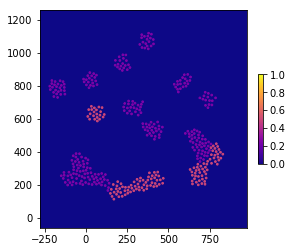

In [41]:
plot([x_data[0]], show=True, save=False)

In [42]:
# `x_data` - input to autoencoder.
# Normalized spike counts for each 200 ms bin.
print(x_data.shape)
print(x_data[:10, :10])
print(np.max(x_data))

(145, 2170)
[[ 0.    0.    0.    0.25  0.    0.    0.    0.25  0.    0.  ]
 [ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.5   0.25  0.    0.    0.    0.    0.    0.    0.    0.5 ]
 [ 0.    0.    0.    0.5   0.    0.    0.    0.75  0.    0.  ]
 [ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.25]
 [ 0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.5 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.25  0.25  0.    0.    0.5   0.    0.  ]]
1.0


In [43]:
# Divide into train and test sets.
div_ind = int(len(x_data)*0.8)
print(div_ind)
x_train = x_data[:div_ind]
x_test = x_data[div_ind:]

116


In [44]:
x_train.shape, x_test.shape

((116, 2170), (29, 2170))

In [45]:
with open('data/incite/x_train.pkl', 'wb') as f:
    pkl.dump(x_train, f)
with open('data/incite/x_test.pkl', 'wb') as f:
    pkl.dump(x_test, f)

# Autoencoder <a class="anchor" id="autoencoder"></a>
## Building <a class="anchor" id="building"></a>

In [36]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

In [37]:
def build_autoenc(encoding_dim=8, input_shape=(2170,), sparsity=0):

    # this is the size of our encoded representations
    encoding_dim = encoding_dim

    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', \
                    activity_regularizer=regularizers.l1(sparsity))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_shape[0], activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (encoding_dim-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')  

    return autoencoder, encoder, decoder

## Training <a class="anchor" id="training"></a>

In [38]:
with open('data/incite/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/incite/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [39]:
# `AppendedHistory` - a class I wrote for one of the miniprojects for ANNs course
#                     and modified for this project.
#                     It allows storing and plotting parametrised learning curves.
from AppendedHistory import AppendedHistory
# Reloads modules automatically when they are changed.
%load_ext autoreload
%autoreload 2

### Simple Autoencoder <a class="anchor" id="simple-autoencoder"></a>

In [ ]:
history_shuffle_300eps = AppendedHistory(varname='Shuffle Before Epoch', keys=['loss'])

In [ ]:
for i in range(3):
    autoencoder, encoder, decoder = build_autoenc()
    history = autoencoder.fit(x_train, x_train, \
                              epochs=300, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/shuffle/autoencoder_300eps_true_{}'.format(i))
    encoder.save('data/incite/models_log/shuffle/encoder_300eps_true_{}'.format(i))
    decoder.save('data/incite/models_log/shuffle/decoder_300eps_true_{}'.format(i))
    history_shuffle_300eps.append_hist(True, history)

In [ ]:
for i in range(3):
    autoencoder, encoder, decoder = build_autoenc()
    history = autoencoder.fit(x_train, x_train, \
                              epochs=300, \
                              batch_size=1, \
                              shuffle=False, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/shuffle/autoencoder_300eps_false_{}'.format(i))
    encoder.save('data/incite/models_log/shuffle/encoder_300eps_false_{}'.format(i))
    decoder.save('data/incite/models_log/shuffle/decoder_300eps_false_{}'.format(i))
    history_shuffle_300eps.append_hist(False, history)

In [ ]:
history_shuffle_300eps.save('data/incite/models_log/shuffle/history_shuffle_300eps')

In [49]:
history_shuffle_300eps = AppendedHistory(fname='data/incite/models_log/shuffle/history_shuffle_300eps')

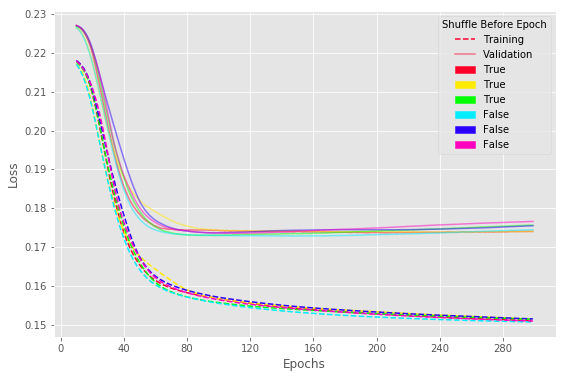

In [50]:
history_shuffle_300eps.plot("", "loss", False, [10, 300])

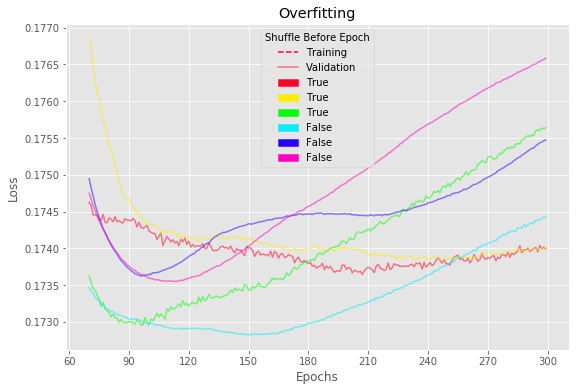

In [51]:
history_shuffle_300eps.plot("Overfitting", "val_loss", False, [70, 300], False)

There is no significant difference in learning for the two types os training (always original `x_train` vs shuffled before each epoch), except that the lines in the first case are smoother.

Given that the sequence shouldn't make difference since I present averaged (complete, 200 ms) patterns, I choose to stick with shuffled option.

In [ ]:
history_shuffle_true_100_200 = AppendedHistory(varname='Shuffle Before Epoch', keys=['loss'])

In [ ]:
for i in range(3):
    autoencoder, encoder, decoder = build_autoenc()
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/shuffle/autoencoder_100eps_true_{}'.format(i))
    encoder.save('data/incite/models_log/shuffle/encoder_100eps_true_{}'.format(i))
    decoder.save('data/incite/models_log/shuffle/decoder_100eps_true_{}'.format(i))
    history_shuffle_true_100_200.append_hist('True_{}'.format(i), history)
    
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/shuffle/autoencoder_200eps_true_{}'.format(i))
    encoder.save('data/incite/models_log/shuffle/encoder_200eps_true_{}'.format(i))
    decoder.save('data/incite/models_log/shuffle/decoder_200eps_true_{}'.format(i))
    history_shuffle_true_100_200.add_hist('True_{}'.format(i), history)

In [ ]:
history_shuffle_true_100_200.save('data/incite/models_log/shuffle/history_shuffle_true_100-200eps')

In [52]:
history_shuffle_true_100_200 = AppendedHistory(fname='data/incite/models_log/shuffle/history_shuffle_true_100-200eps')

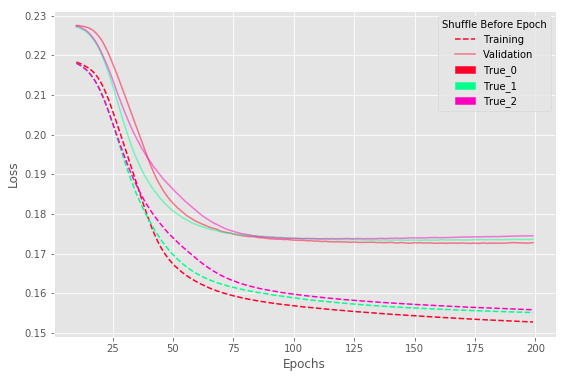

In [53]:
history_shuffle_true_100_200.plot("", "loss", False, [10, 200])

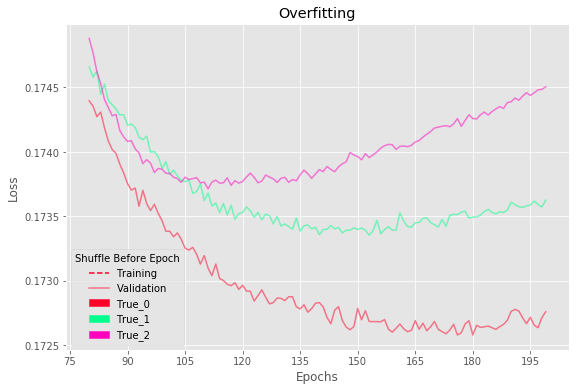

In [54]:
history_shuffle_true_100_200.plot("Overfitting", "val_loss", False, [80, 200], False)

Here, model corresponding to `True_0` in the best.

### Sparse Autoencoder <a class="anchor" id="sparse-autoencoder"></a>

In [11]:
history_sparse_100_200 = AppendedHistory(varname='Sparsity', keys=['loss'])

In [17]:
sparsities = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2]
for sparsity in sparsities:
    autoencoder, encoder, decoder = build_autoenc(sparsity=sparsity)
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/sparse/autoencoder_100eps_sp_{}'.format(sparsity))
    encoder.save('data/incite/models_log/sparse/encoder_100eps_sp_{}'.format(sparsity))
    decoder.save('data/incite/models_log/sparse/decoder_100eps_sp_{}'.format(sparsity))
    history_sparse_100_200.append_hist(sparsity, history)
    
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/sparse/autoencoder_200eps_sp_{}'.format(sparsity))
    encoder.save('data/incite/models_log/sparse/encoder_200eps_sp_{}'.format(sparsity))
    decoder.save('data/incite/models_log/sparse/decoder_200eps_sp_{}'.format(sparsity))
    history_sparse_100_200.add_hist(sparsity, history)

In [12]:
history_sparse_100_200.save('data/incite/models_log/sparse/history_sparse_100-200eps')

In [13]:
history_sparse_100_200 = AppendedHistory(fname='data/incite/models_log/sparse/history_sparse_100-200eps')

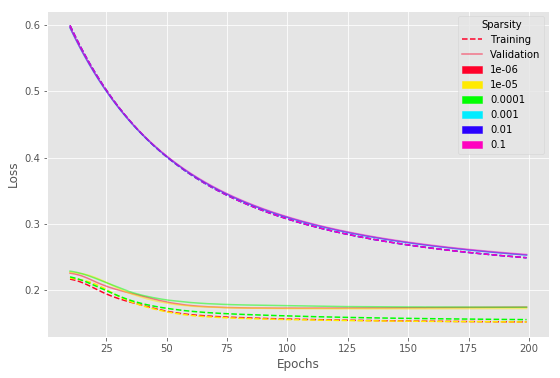

In [14]:
history_sparse_100_200.plot("", "loss", False, [10, 200])

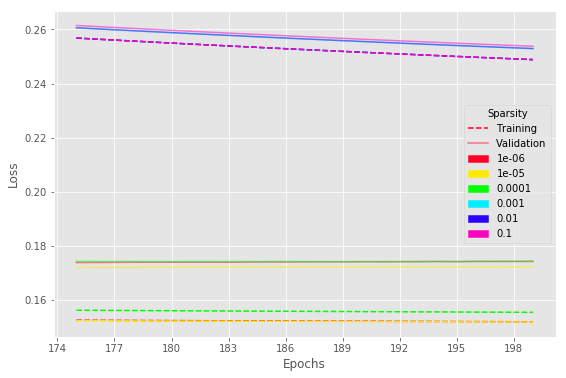

In [15]:
history_sparse_100_200.plot("", "loss", False, [175, 200])

In [33]:
fnames = ['data/incite/models_log/sparse/encoder_100eps_sp_1e-05', \
          'data/incite/models_log/sparse/encoder_200eps_sp_1e-05']
get_comp_hist(fnames, labels=['decoded_100', 'decoded_200'])

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


**NB** On some histograms

- for `decoded_100`: there is one blob in the middle,
- for `decoded_200`: this blob divides into two.

This might mean that sparse autoencoder better represents the dataset.

### Low-dimentional Autoencoder <a class="anchor" id="lim-dim-ae"></a>

In [44]:
history_encdims = AppendedHistory(varname='Encoding Dimension', keys=['loss'])

In [45]:
for i in [2, 4, 6]:
    autoencoder, encoder, decoder = build_autoenc(encoding_dim=i)
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/encdims/autoencoder_encdim_{}_100eps'.format(i))
    encoder.save('data/incite/models_log/encdims/encoder_encdim_{}_100eps'.format(i))
    decoder.save('data/incite/models_log/encdims/decoder_encdim_{}_100eps'.format(i))
    history_encdims.append_hist(i, history)
    
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/encdims/autoencoder_encdim_{}_200eps'.format(i))
    encoder.save('data/incite/models_log/encdims/encoder_encdim_{}_200eps'.format(i))
    decoder.save('data/incite/models_log/encdims/decoder_encdim_{}_200eps'.format(i))
    history_encdims.add_hist(i, history)

In [48]:
history_encdims.save('data/incite/models_log/encdims/history_encdims')

In [49]:
history_encdims = AppendedHistory(fname='data/incite/models_log/encdims/history_encdims')

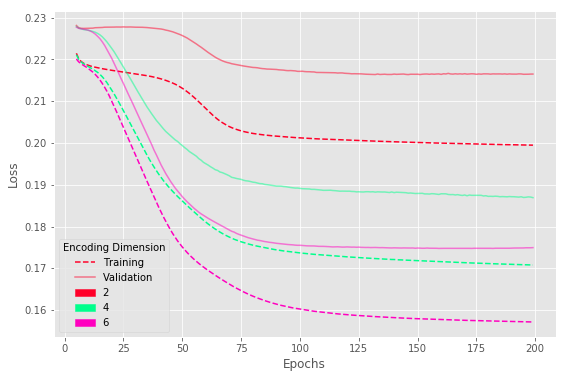

In [52]:
history_encdims.plot("", "loss", False, [5, 200], True)

# Readout/Classifier <a class="anchor" id="readout"></a>
## Dataset Preparation<a class="anchor" id="dataset-preparation"></a>

In [4]:
with open('data/incite/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/incite/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [5]:
encoder = load_model('data/incite/models_log/shuffle/encoder_200eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [32]:
cl_x_train_in = encoder.predict(x_train)
cl_x_test_in = encoder.predict(x_test)

In [19]:
with open('data/input/stim_train.pkl', 'rb') as f:
    stim_train = pkl.load(f)

In [25]:
stim_train_2_one_hot = {}
one_hot = np.zeros(8)
for i, pattern in enumerate(np.unique(stim_train)):
    hot = np.copy(one_hot)
    hot[i] = 1
    stim_train_2_one_hot[pattern] = hot

In [26]:
stim_train_2_one_hot

{205315: array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 249980: array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 397555: array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 446691: array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 515018: array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 740558: array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 757795: array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 766947: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])}

In [29]:
cl_x_train_out = np.array([stim_train_2_one_hot[pattern] for pattern in stim_train[:116]])
cl_x_test_out = np.array([stim_train_2_one_hot[pattern] for pattern in stim_train[116:]])

In [33]:
with open('data/incite/cl_x_train_in.pkl', 'wb') as f:
    pkl.dump(cl_x_train_in, f)
with open('data/incite/cl_x_test_in.pkl', 'wb') as f:
    pkl.dump(cl_x_test_in, f)
with open('data/incite/cl_x_train_out.pkl', 'wb') as f:
    pkl.dump(cl_x_train_out, f)
with open('data/incite/cl_x_test_out.pkl', 'wb') as f:
    pkl.dump(cl_x_test_out, f)

## Building <a class="anchor" id="cl_building"></a>

In [34]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

In [41]:
def build_classifier(output_dim=8, hidden_dim=16, input_shape=(8,), sparsity=0):

    output_dim = output_dim

    input_repr = Input(shape=input_shape)
    layer_1 = Dense(hidden_dim, activation='relu', \
                    activity_regularizer=regularizers.l1(sparsity))(input_repr)
    layer_2 = Dense(hidden_dim, activation='relu', \
                    activity_regularizer=regularizers.l1(sparsity))(layer_1)
    output_layer = Dense(output_dim, activation='sigmoid')(layer_2)

    # this model maps an input to its reconstruction
    classifier = Model(input_repr, output_layer)

    classifier.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])  

    return classifier

## Training <a class="anchor" id="cl_training"></a>

In [4]:
from AppendedHistory import AppendedHistory
%load_ext autoreload
%autoreload 2

In [50]:
history_cl_dims_100_200 = AppendedHistory(varname='Hidden Layers Dimension', keys=['loss', 'acc'])

In [53]:
hidden_dims = [8, 12, 16]
for hidden_dim in hidden_dims:
    classifier = build_classifier(hidden_dim=hidden_dim)
    history = classifier.fit(cl_x_train_in, cl_x_train_out, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(cl_x_test_in, cl_x_test_out), \
                              verbose=0)
    classifier.save('data/incite/models_log/readout/classifier_dims_{}_100-1'.format(hidden_dim))
    history_cl_dims_100_200.append_hist(hidden_dim*10 + 1, history)
    
    history = classifier.fit(cl_x_train_in, cl_x_train_out, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(cl_x_test_in, cl_x_test_out), \
                              verbose=0)
    classifier.save('data/incite/models_log/readout/classifier_dims_{}_200-1'.format(hidden_dim))
    history_cl_dims_100_200.add_hist(hidden_dim*10 + 1, history)

In [281]:
history_cl_dims_100_200 = AppendedHistory(fname='data/incite/models_log/readout/history_cl_dims_100-200eps')

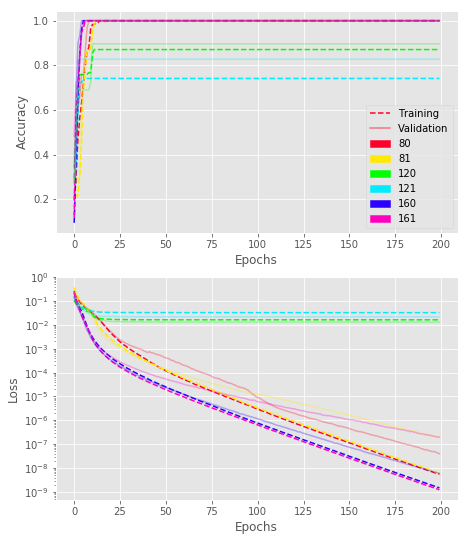

In [282]:
history_cl_dims_100_200.plot_acc_loss("", "", "val_")

In [12]:
history_cl_dims_100_200.save('data/incite/models_log/readout/history_cl_dims_100-200eps')

# Analysis <a class="anchor" id="analysis"></a>
## Analytical Tools Development <a class="anchor" id="analytical-tools-development"></a>
### Comparative Histogram <a class="anchor" id="comparative-histogram"></a>
Here, I use the best [Simple Autoencoder](#simple-autoencoder) model.

`decoded` vs `x_test` distributions for each test vector.

In [55]:
with open('data/incite/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/incite/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)
x_data = np.vstack((x_train, x_test))

In [53]:
encoder = load_model('data/incite/models_log/shuffle/encoder_100eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_100eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [57]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_100 = encoder.predict(x_test)
decoded_100 = decoder.predict(encoded_100)

In [58]:
encoder = load_model('data/incite/models_log/shuffle/encoder_200eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_200eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [59]:
encoded_200 = encoder.predict(x_test)
decoded_200 = decoder.predict(encoded_200)

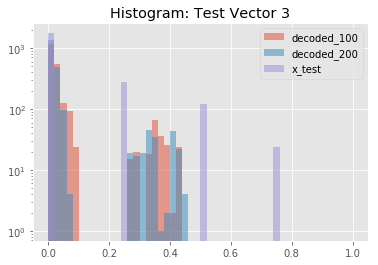

In [60]:
i = 3 # Insert i from 0 to 28.
with plt.style.context('ggplot'):
    plt.hist(decoded_100[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='decoded_100')
    plt.hist(decoded_200[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='decoded_200')
    plt.hist(x_test[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='x_test')
    plt.title("Histogram: Test Vector {}".format(i))
    plt.legend()
plt.show()

In [32]:
def get_comp_hist(fnames, labels=None):
    if labels == None:
        labels = ["decoded_{}".format(i) for i in range(len(fnames))]
    with plt.style.context('ggplot'):
        decodeds = []
        for fname, label in zip(fnames, labels):
            encoder = load_model(fname)
            decoder = load_model(fname.replace("encoder", "decoder"))
            encoded = encoder.predict(x_test)
            decoded = decoder.predict(encoded)
            decodeds.append(decoded)
        for test_num in range(x_test.shape[0]):
            for decoded in decodeds:
                plt.hist(decoded[test_num], log=True, bins=50, range=[0, 1], alpha=0.5, label=label)
            plt.hist(x_test[test_num], log=True, bins=50, range=[0, 1], alpha=0.5, label='x_test')
            plt.title("Histogram: Test Vector {}".format(test_num))
            plt.legend()
            plt.savefig('data/incite/models_log/sparse/comp_hist/comp_hist_{}.pdf'.format(test_num), dpi=300)
            plt.clf()

As we see in the histogram, the values of the decoded images form 2 "groups", not 4 (like the input):
- close to 0,
- somewhere in between 0.2-0.6 (different for different patterns).

Seems like the autoencoder only differentiates between "most probably shouldn't be active" and "might be active".

Note that this kind of distribution is more or less what we should get due to the initial probabilistic approach.

In [61]:
print("decoded_100 - max value: {}".format(np.max(np.abs(decoded_100))))
print("decoded_200 - max value: {}".format(np.max(np.abs(decoded_200))))
print("max abs difference:      {}".format(np.max(np.abs(decoded_100 - decoded_200))))

decoded_100 - max value: 0.6333586573600769
decoded_200 - max value: 0.6711538434028625
max abs difference:      0.1351766288280487


### Comparative Animation <a class="anchor" id="comparative-animation"></a>

Visualization of `decoded` vs `x_test` by taking one test vector at a time.

In [62]:
plot([decoded_100, x_test], ['Decoded', 'Test'], '', 'comparison_100eps.png')

### Working with Patterns <a class="anchor" id="working-with-patterns"></a>

In [144]:
with open('data/input/stim_train.pkl', 'rb') as f:
    stim_train = pkl.load(f)

In [145]:
# `d_data` - dictionary of all indices of each pattern, dict.
d_data = {}
for i in np.unique(stim_train):
    d_data[i] = np.argwhere(stim_train == i).reshape(-1)

In [146]:
d_data

{205315: array([  3,  16,  17,  40,  48,  50,  51,  55,  81,  84,  86,  90,  91,
        101, 104, 132, 144]),
 249980: array([  0,   5,   9,  11,  22,  29,  46,  56,  70,  77,  89, 105, 109,
        127, 130, 134, 137, 138, 142]),
 397555: array([  1,   4,   7,  10,  27,  31,  35,  44,  45,  61,  63,  69,  96,
        100, 102, 103, 107, 139, 143]),
 446691: array([  2,  14,  30,  38,  49,  52,  54,  59,  68,  71,  74,  95, 112,
        116, 117, 120, 121, 129, 133]),
 515018: array([ 19,  23,  26,  43,  47,  57,  65,  72,  73,  75,  78,  83,  92,
         94,  99, 119, 126, 140]),
 740558: array([  8,  13,  20,  21,  25,  28,  37,  41,  53,  66,  82,  85,  88,
         93, 106, 123, 124]),
 757795: array([  6,  24,  32,  34,  42,  60,  62,  64,  67,  79,  97, 108, 110,
        113, 118, 128, 136, 141]),
 766947: array([ 12,  15,  18,  33,  36,  39,  58,  76,  80,  87,  98, 111, 114,
        115, 122, 125, 131, 135])}

In [147]:
d_train = {key: d_data[key][np.where(d_data[key] < 116)] for key in d_data.keys()}

In [148]:
d_test = {key: d_data[key][np.where(d_data[key] >= 116)]-116 for key in d_data.keys()}

#### Pattern Sums  <a class="anchor" id="pattern-sums"></a>

In [149]:
# `sums` - normalized sums of the activations of all instances of each pattern, list of 1darrays.
def get_sums(d_data, x_data):
    sums = []
    for key in d_data.keys():
        sum_ = x_data[d_data[key][0]]
        for i in d_data[key][1:]:
            sum_ = sum_ + x_data[i]
        sum_ = sum_ / np.max(sum_)
        sums.append(sum_)
    return sums

In [150]:
sums = get_sums(d_data, x_data)

In [ ]:
for i, key in enumerate(d_data.keys()):
    plot([sums[i]], ['Pattern {}: Input Sum'.format(str(key))], '', 'models_log/shuffle/pattern_sums_input/pattern_sum_{}.pdf'.format(key))

In [71]:
sums_decoded = get_sums(d_test, decoded_100)

In [ ]:
for i, key in enumerate(d_data.keys()):
    plot([sums_decoded[i]], ['Pattern {}: Decoded Sum'.format(str(key))], '', 'models_log/shuffle/pattern_sums_decoded/pattern_sum_{}.pdf'.format(key))

#### Patterns Distributions <a class="anchor" id="pattern-distributions"></a>

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
# `distribs` - distributions of encoded representations for each test pattern, list of 1darrays.
distribs = []
for key in d_test.keys():
    distrib = []
    for i in d_test[key]:
        distrib.append(encoded_imgs[i])
    distrib = np.array(distrib)
    distribs.append(distrib)

In [ ]:
with plt.style.context('ggplot'):
    for i, key in enumerate(d_test.keys()):
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.set_ylim(0, 20)
        for distrib in distribs[i]:
            arr = np.vstack((np.arange(8)+1, distrib)).T
            ax.scatter(arr[:, 0], arr[:, 1], alpha=0.7)
        ax.set_title("Pattern {}: Decoded Distribution".format(key))
        fig.savefig("data/incite/models_log/shuffle/pattern_distribs/pattern_distrib_{}.png".format(key), dpi=300)

#### Summary Table <a class="anchor" id="summary-table"></a>

446691 | 757795 | 766947
--- | --- | ---
<img src="data/incite/models_log/shuffle/pattern_sums_decoded/pattern_sum_446691.png" /> | <img src="data/incite/models_log/shuffle/pattern_sums_decoded/pattern_sum_757795.png" /> | <img src="data/incite/models_log/shuffle/pattern_sums_decoded/pattern_sum_766947.png" />
<img src="data/incite/models_log/shuffle/pattern_sums_input/pattern_sum_446691.png" /> | <img src="data/incite/models_log/shuffle/pattern_sums_input/pattern_sum_757795.png" /> | <img src="data/incite/models_log/shuffle/pattern_sums_input/pattern_sum_766947.png" />
<img src="data/incite/models_log/shuffle/pattern_distribs/pattern_distrib_446691.png" /> | <img src="data/incite/models_log/shuffle/pattern_distribs/pattern_distrib_757795.png" /> | <img src="data/incite/models_log/shuffle/pattern_distribs/pattern_distrib_766947.png" />

### Dimensional Representation Visualization <a class="anchor" id="dim-repr-viz"></a>

In [4]:
with open('data/incite/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [69]:
encoder = load_model('data/incite/models_log/shuffle/encoder_100eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_100eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [70]:
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

In [ ]:
for j in range(x_test.shape[0]):
    plot([decoded[j]], \
         ['Decoded', 'Original'], 'Test Vector {}'.format(j), \
         "models_log/shuffle/dim_viz/vect_{}_comparison.pdf".format(j))

In [97]:
decoded_new_all_zeros = []
for i in range(encoded.shape[1]):
    encoded_new = np.zeros((encoded.shape[0], encoded.shape[1]))
    encoded_new[:, i] = encoded[:, i]
    decoded_new = decoder.predict(encoded_new)
    decoded_new_all_zeros.append(decoded_new)
decoded_new_all_zeros = np.array(decoded_new_all_zeros)

In [98]:
decoded_new_all_ones = []
for i in range(encoded.shape[1]):
    encoded_new = np.ones((encoded.shape[0], encoded.shape[1]))
    encoded_new[:, i] = encoded[:, i]
    decoded_new = decoder.predict(encoded_new)
    decoded_new_all_ones.append(decoded_new)
decoded_new_all_ones = np.array(decoded_new_all_ones)

In [ ]:
for i in range(encoded.shape[1]):
    for j in [15, 17]:
        plot([decoded_new_all_ones[i, j, :]], \
             ['Representation Dimention {}'.format(i)], \
             '', "models_log/shuffle/dim_viz/{}/vect_{}_repr_only_{}.png".format(j, j, i))

In [ ]:
for i in range(encoded.shape[1]):
    for j in [15, 17]:
        plot([decoded_new_all_zeros[:, j, :], decoded_new_all_ones[:, j, :], \
             [decoded[j]]*encoded.shape[1], [x_test[j]]*encoded.shape[1]], \
             ['Zeros', 'Ones', 'Decoded', 'Original'], \
             'Test Vector {}'.format(j), "models_log/shuffle/dim_viz/{}/vect_{}_reprs".format(j))

#### Example Tables <a class="anchor" id="ex-tables"></a>

| | | Vector 15
--- | --- | --- | ---
<img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_0.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_1.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_2.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_3.png" />
<img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_4.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_5.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_6.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_7.png" />
<img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_decoded.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_test.png" />

| | | Vector 17
--- | --- | --- | ---
<img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_0.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_1.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_2.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_3.png" />
<img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_4.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_5.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_6.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_7.png" />
<img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_decoded.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_test.png" />

### Weights Visualization <a class="anchor" id="weights-viz"></a>

In [103]:
with open('data/incite/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/incite/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)
x_data = np.vstack((x_train, x_test))

In [104]:
encoder = load_model('data/incite/models_log/shuffle/encoder_100eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_100eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [246]:
for i in range(8):
    plot([encoder.get_weights()[0].T[i]], ['Encoder Weights {}'.format(i)], '', \
         "models_log/shuffle/weights_viz/encoder_weights_{}.pdf".format(i), scale_to_01=False, ticksize=5)

In [247]:
for i in range(8):
    plot([decoder.get_weights()[0][i]], ['Decoder Weights {}'.format(i)], '', \
         "models_log/shuffle/weights_viz/decoder_weights_{}.pdf".format(i), scale_to_01=False, ticksize=5)

In [279]:
# Normalize weights.
d_weights = decoder.get_weights()[0]
d_weights = (d_weights - np.min(d_weights)) / (np.max(d_weights)-np.min(d_weights))

In [255]:
for i, key in enumerate(d_data.keys()):
    mins = np.min(np.abs(d_weights - np.tile(sums[i], (8, 1))), axis=1)
    argmins = mins.argsort()
    plot([sums[i], d_weights[argmins[0]], d_weights[argmins[1]]], \
         ['Sum', 'Decoder Weights {}'.format(argmins[0]), 'Decoder Weights {}'.format(argmins[1])], \
         'Pattern {}'.format(key), \
         "models_log/shuffle/sums_vs_weights_pattern_{}.pdf".format(key))

In [264]:
# Get positive weights, normalize.
d_weights_pos = decoder.get_weights()[0]
d_weights_pos = np.where(d_weights_pos >= 0, d_weights_pos, 0)
d_weights_pos = (d_weights_pos - np.min(d_weights_pos)) / (np.max(d_weights_pos)-np.min(d_weights_pos))

In [276]:
# Get negative weights, normalize.
d_weights_neg = decoder.get_weights()[0]
d_weights_neg = np.where(d_weights_neg < 0, np.abs(d_weights_neg), 0)
d_weights_neg = (d_weights_neg - np.min(d_weights_neg)) / (np.max(d_weights_neg)-np.min(d_weights_neg))

In [280]:
# Plot normalized weights.
for i in range(8):
    plot([d_weights_pos[i], d_weights_neg[i], d_weights[i]], \
         ['Positive', 'Negative', 'All'], \
         'Decoder Weights {}'.format(i), \
         "models_log/shuffle/weights_viz/decoder_weights_compare_{}.pdf".format(i))

**NB:** For negative weights, the more negative the weight, the brighter the color.

<img src="data/incite/models_log/shuffle/weights_viz/decoder_weights_compare_3.pdf" />

### Clustering Visualization <a class="anchor" id="clustering-viz"></a>

In [285]:
with open('data/incite/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [286]:
with open('data/input/stim_train.pkl', 'rb') as f:
    stim_train = pkl.load(f)

In [292]:
# `d_data` - dictionary of all indices of each pattern, dict.
d_data = {}
for i in np.unique(stim_train):
    d_data[i] = np.argwhere(stim_train == i).reshape(-1)

In [296]:
d_patt = {key: i for i, key in enumerate(d_data.keys())}

In [301]:
stim_nums = np.array([d_patt[patt_name] for patt_name in stim_train])

In [338]:
encoder = load_model('data/incite/models_log/encdims/encoder_encdim_2_200eps')
decoder = load_model('data/incite/models_log/encdims/decoder_encdim_2_200eps')
encoded = encoder.predict(x_data)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


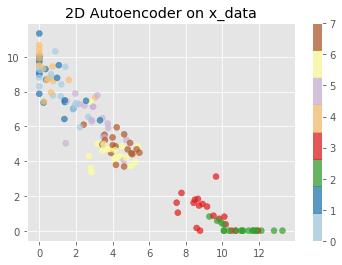

In [339]:
with plt.style.context('ggplot'):
    plt.scatter(encoded[:, 0], encoded[:, 1], c=stim_nums, cmap=plt.cm.get_cmap('Paired', 8), alpha=0.7)
    plt.title('2D Autoencoder on x_data')
    plt.colorbar()
plt.savefig('data/incite/clustering/x_data_2d_ae.pdf', dpi=300)
plt.show()

In [341]:
encoder = load_model('data/incite/models_log/shuffle/encoder_100eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_100eps_true_0')
encoded = encoder.predict(x_data)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [347]:
for i in range(8):
    for j in range(i+1, 8):
        with plt.style.context('ggplot'):
            plt.scatter(encoded[:, i], encoded[:, j], c=stim_nums, cmap=plt.cm.get_cmap('Paired', 8), alpha=0.7)
            plt.title('8D Autoencoder on x_data: {} vs {}'.format(i, j))
            plt.colorbar()
        plt.savefig('data/incite/clustering/x_data_8d_ae_{}_vs_{}.png'.format(i, j), dpi=300)
        plt.close('all')

#### 8D AE Summary Table <a class="anchor" id="8d-ae-table"></a>

1| 2| 3| 4| 5| 6| 7
--- | --- | --- | --- | --- | --- | --- | ---
<img src="data/incite/clustering/x_data_8d_ae_0_vs_1.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_2.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_3.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_4.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_7.png" />
| <img src="data/incite/clustering/x_data_8d_ae_1_vs_2.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_3.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_4.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_7.png" />
|| <img src="data/incite/clustering/x_data_8d_ae_2_vs_3.png" /> | <img src="data/incite/clustering/x_data_8d_ae_2_vs_4.png" /> | <img src="data/incite/clustering/x_data_8d_ae_2_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_2_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_2_vs_7.png" />
||| <img src="data/incite/clustering/x_data_8d_ae_3_vs_4.png" /> | <img src="data/incite/clustering/x_data_8d_ae_3_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_3_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_3_vs_7.png" />
|||| <img src="data/incite/clustering/x_data_8d_ae_4_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_4_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_4_vs_7.png" />
||||| <img src="data/incite/clustering/x_data_8d_ae_5_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_5_vs_7.png" />
|||||| <img src="data/incite/clustering/x_data_8d_ae_6_vs_7.png" />

In [313]:
import tsne

In [324]:
tsned = tsne.tsne(x_data, 2, x_test.shape[0])

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 145...
Mean value of sigma: 3.787110
Iteration 10: error is 11.346244
Iteration 20: error is 8.872359
Iteration 30: error is 9.369819
Iteration 40: error is 9.124946
Iteration 50: error is 8.799971
Iteration 60: error is 8.595849
Iteration 70: error is 8.812338
Iteration 80: error is 8.678602
Iteration 90: error is 8.285623
Iteration 100: error is 8.572423
Iteration 110: error is 1.060683
Iteration 120: error is 0.634083
Iteration 130: error is 0.388669
Iteration 140: error is 0.239319
Iteration 150: error is 0.132315
Iteration 160: error is 0.105820
Iteration 170: error is 0.080707
Iteration 180: error is 0.070482
Iteration 190: error is 0.065259
Iteration 200: error is 0.062296
Iteration 210: error is 0.061071
Iteration 220: error is 0.060795
Iteration 230: error is 0.060723
Iteration 240: error is 0.060693
Iteration 250: error is 0.060671
Iteration 260: error is 0.060655
Iteration 2

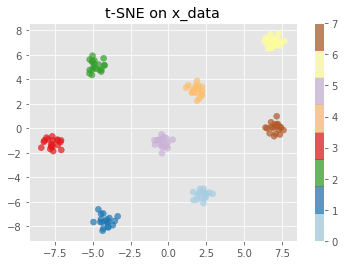

In [335]:
with plt.style.context('ggplot'):
    plt.scatter(tsned[:, 0], tsned[:, 1], c=stim_nums, cmap=plt.cm.get_cmap('Paired', 8), alpha=0.7)
    plt.title("t-SNE on x_data")
    plt.colorbar()
plt.savefig('data/incite/clustering/x_data_2d_tsne.pdf', dpi=300)
plt.show()

#### TODO <a class="anchor" id="todo"></a>
- Generate more data? (◎)
    - Get access to data generator? (◎)
- Compare representations (✓) and decoded images (✓) for the same patterns
- Insert examples of plots that are only saved, not shown (✓)
- Compare the results for different bottleneck sizes (◎)
- Compare representations of similar patterns (manifold learning) (◎)
- Look up t-SNE (◎)
- Check what every particular representation dimention codes for (◎)
    - Set all the others at zero and look what's there

#### Project Log <a class="anchor" id="project-log"></a>

**26.10.2018**
- Finished major clean up:
    - Got rid of irrelevant/old code/markdown
        - To make the contents tell a congruent story.
    - Notebook is no more structured by date, reasons being that:
        - I continue to improve what I've done before,
        - I clean up a lot of irrelevant info,
        - Transparent versioning (thx to GitHub) is still there.
- Created a new outline:
    - Each section and most revelant subsections can be loaded independently,
    - Table of contents:
        - Multilevel list,
        - Clickable.
- Modified `AppendedHistory` for the project
    - And used it throughout training (and will continue to use).
- Observed the effect of shuffling before each epoch on the learning process.
    - Visualized the best model.
        - [Comparative Histogram](#comparative-histogram) first done today.

**29.10.2018**
- Switched [Comparative Histogram](#comparative-histogram)'s scale to log.
- Solved the issue with markdown images on GitHub.

**30.10.2018**
- Added [Sparse Autoencoder](#sparse-autoencoder)
- Added `get_comp_hist()` function

**30.10.2018** Meeting
- Train a CNN ?
    - Spatial invariance
- **How do we access that the bio model is learning?**
    - ICE
    - Apply the same principles to autoencoder
- Some neurons become selective to specific stimuli
    - Visualise autoencoder weights ?
- More meaningful metrics
    - R^2
- Sequences
    - Now randomly
    - Might be rules
        - Compare robustness
    - Epochs ?
    - Not the case for now
- **Regular presentations**
    - First pres
        - Intro slides
            - Dataset
            - Problem
- Readout
    - Lower bound on the amount on info present in the system
        - Lower bound nontrivial and high enough => learning happening
    - Classifier/single-layer perceptron on the activity in the circuit
        - Reading out the info that's already there
        - Liquid Computing
            - Linearity is important
        - Acoustic Networks

**Next time:**
- Train a classifier on the representations
    - Pattern completion
        - As remove more and more blobs, trained network will have some degree of robustness
        - Higher bottleneck size will yield results comparable with naive
    - Think of a naive benchmark
        - Compare readout from random (naive) network and trained network
        - Compare readout in the input vs representation layer
- t-SNE on input vs representation layer
- Visualise each dimention
- Visualise autoencoder weights (look up in ANNs miniproject2)
- Representing blobs
    - Try 1-2 epochs, see whether learns blobs

**Not now:**
- Variate bottleneck sizes
- Add an additional layer

**2.11.2018**
- Worked on [Readout/Classifier](#readout).
    - Prepared datasets for classifier training.
    - Trained classifiers with different hidden layer size.